## 線形回帰、多項式回帰
多重線形回帰、多項式回帰によりyを予測してみる。<br>
RSSが最も小さい予測変数から順に10,15,20,25,30,35,40個の変数を用いるモデルを組み、どれが一番正答率が高いかを調べる<br>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
import preprocesses
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score


In [3]:
#データの読み込み
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
new_train=train[preprocesses.train_valiable_list]
new_test=test[preprocesses.test_valiable_list]
new_train=preprocesses.preprocess(new_train)
new_test=preprocesses.preprocess(new_test)
new_train["SalePrice"]=np.log(new_train["SalePrice"])

/Users/Naomi/Desktop/git_clones/MachineLearning/House_Prices/preprocesses.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t[k]= t[k].map(five_map1)
/Users/Naomi/Desktop/git_clones/MachineLearning/House_Prices/preprocesses.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t["BsmtExposure"]= t["BsmtExposure"].map(five_map2)
/Users/Naomi/Desktop/git_clones/MachineLearning/House_Prices/preprocesses.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [5]:
new_train.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,SalePrice,Baths
0,65.0,8450,7,5,2003,2003,196.0,4,3,4,...,61,0,0,0,0,0,0,2008,12.247694,4
1,80.0,9600,6,8,1976,1976,0.0,3,3,4,...,0,0,0,0,0,0,0,2007,12.109011,3
2,68.0,11250,7,5,2001,2002,162.0,4,3,4,...,42,0,0,0,0,0,0,2008,12.317167,4
3,60.0,9550,7,5,1915,1970,0.0,3,3,3,...,35,272,0,0,0,0,0,2006,11.849398,2
4,84.0,14260,8,5,2000,2000,350.0,4,3,4,...,84,0,0,0,0,0,0,2008,12.429216,4


In [93]:
y=new_train[["SalePrice"]]
X=new_train.drop(["SalePrice"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=2020)
linearmodel=Pipeline([('poly', PolynomialFeatures(degree=1)),('linear', LinearRegression())]).fit(X_train, y_train["SalePrice"])

In [94]:
np.sqrt(mean_squared_error(y_valid['SalePrice'], linearmodel.predict(X_valid)))

0.143781980986776

In [95]:
r2_score(y_valid, linearmodel.predict(X_valid))

0.8824369392479181

決定係数$R^2$スコア(当てはまりが良いと1になる)はとても良さそう…？

# 交差検証
訓練データ(new_train)を4:1で訓練・バリデーションに使う<br>

In [53]:
RMSE=[]
r2_scores=[]
testRMSE=[]
for porder in range(1,4):
    print(porder)
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)),('linear', LinearRegression())])
    k_fold = KFold(n_splits=5)
    test_MSE = cross_validate(model,  X_train, y_train, cv=k_fold, scoring=('r2', 'neg_mean_squared_error'))
    RMSE.append(np.sqrt(np.mean(-test_MSE['test_neg_mean_squared_error'])))
    mdl=Pipeline([('poly', PolynomialFeatures(degree=porder)),('linear', LinearRegression())])
    mdl.fit(X_train, y_train["SalePrice"])
    testRMSE.append(np.sqrt(mean_squared_error(y_valid['SalePrice'], mdl.predict(X_valid))))
    r2_scores.append(np.mean(test_MSE['test_r2']))

1
2
3


In [54]:
print(RMSE)
print(testRMSE)

[0.35370691975597446, 15157.620262675682, 72.0482568149145]
[0.143781980986776, 5.574106814690894, 5.266005113157865]


In [55]:
r2_scores

[0.2512918626760753, -1324254081.6783702, -30926.34939583192]

No handles with labels found to put in legend.


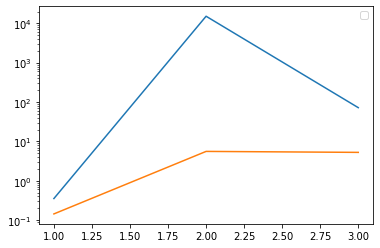

In [56]:
plt.plot([1,2,3],RMSE)
plt.plot([1,2,3],testRMSE)
plt.legend()
plt.yscale("log")
plt.show()

# forward selection
先ほどの結果より線形回帰で十分そうなので、線形回帰を用います。
予測変数無しのモデルから出発し、RSSが最も小さい予測変数を追加するということを繰り返す。Forward selectionが実装されている、mlxtendというライブラリーを用いました。

In [57]:
model = Pipeline([('poly', PolynomialFeatures(degree=1)),('linear', LinearRegression())])
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(model, # 使う学習器
           k_features=45, #特徴をいくつまで選択するか
           forward=True, #Trueでforward selectionになる。Falseでback
           verbose=2, #実行時のlogをどれだけ詳しく表示するか
           scoring='neg_mean_squared_error', # 評価指標
           cv=5) #クロスバリデーション
sfs1 = sfs1.fit(new_train.drop(["SalePrice"],axis=1), new_train["SalePrice"])
sfs1.subsets_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.4s finished

[2020-08-03 17:19:55] Features: 1/45 -- score: -0.05308652079871525[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    0.4s finished

[2020-08-03 17:19:56] Features: 2/45 -- score: -0.04199733089507811[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    0.4s finished

[2020-08-03 17:19:56] Features: 3/45 -- score: -0.034608878396070075[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]:

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.4s finished

[2020-08-03 17:20:06] Features: 28/45 -- score: -0.02147392837548802[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.3s finished

[2020-08-03 17:20:06] Features: 29/45 -- score: -0.02150062453161044[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished

[2020-08-03 17:20:06] Features: 30/45 -- score: -0.02152794604641381[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished

[2020-08-03 17:20:07] Feature

{1: {'feature_idx': (2,),
  'cv_scores': array([-0.04980155, -0.06251804, -0.05522964, -0.04511045, -0.05277293]),
  'avg_score': -0.05308652079871525,
  'feature_names': ('OverallQual',)},
 2: {'feature_idx': (2, 44),
  'cv_scores': array([-0.03774825, -0.04636211, -0.04431548, -0.03656329, -0.04499753]),
  'avg_score': -0.04199733089507811,
  'feature_names': ('OverallQual', 'Baths')},
 3: {'feature_idx': (2, 18, 44),
  'cv_scores': array([-0.02938948, -0.03802265, -0.03277377, -0.02899447, -0.04386401]),
  'avg_score': -0.034608878396070075,
  'feature_names': ('OverallQual', '1stFlrSF', 'Baths')},
 4: {'feature_idx': (2, 18, 30, 44),
  'cv_scores': array([-0.02685902, -0.03428358, -0.03176604, -0.02688683, -0.03765032]),
  'avg_score': -0.03148915797780061,
  'feature_names': ('OverallQual', '1stFlrSF', 'GarageCars', 'Baths')},
 5: {'feature_idx': (2, 3, 18, 30, 44),
  'cv_scores': array([-0.02578019, -0.0328732 , -0.02974545, -0.02414681, -0.03505269]),
  'avg_score': -0.029519668

In [167]:
print(sfs1.subsets_[35]['feature_names'])

('LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'YrSold', 'Baths')


In [80]:
new_train_valiable_list5=['OverallQual', 'OverallCond', '1stFlrSF', 'GarageCars', 'Baths']
new_train_valiable_list10=['OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinType1', 'HeatingQC', '1stFlrSF', 'GrLivArea', 'FireplaceQu', 'GarageCars', 'Baths']
new_train_valiable_list15=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'KitchenQual', 'FireplaceQu', 'GarageCars', 'ScreenPorch', 'Baths']
new_train_valiable_list20=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtQual', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'KitchenQual', 'FireplaceQu', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolQC', 'Baths']
new_train_valiable_list25=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual', 'FireplaceQu', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Baths']
new_train_valiable_list30=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'YrSold', 'Baths']
new_train_valiable_list35=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'YrSold', 'Baths']
new_train_valiable_list40=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold', 'Baths']

In [85]:
RMSE=[]
r2_scores=[]
testRMSE=[]
for i in range(1,46):
    valiables=list(sfs1.subsets_[i]['feature_names'])
    model = Pipeline([('poly', PolynomialFeatures(degree=1)),('linear', LinearRegression())])
    k_fold = KFold(n_splits=5)
    test_MSE = cross_validate(model, X_train[valiables], y_train, 
                           cv=k_fold, scoring=('r2', 'neg_mean_squared_error'))
    RMSE.append(np.sqrt(np.mean(-test_MSE['test_neg_mean_squared_error'])))
    mdl=Pipeline([('poly', PolynomialFeatures(degree=1)),('linear', LinearRegression())])
    mdl.fit(X_train[valiables], y_train["SalePrice"])
    testRMSE.append(np.sqrt(mean_squared_error(y_valid['SalePrice'], mdl.predict(X_valid[valiables]))))
    r2_scores.append(np.mean(test_MSE['test_r2']))

In [88]:
print(np.min(RMSE))
print(RMSE.index(np.min(RMSE)))
print(np.min(testRMSE))
print(testRMSE.index(np.min(testRMSE)))

0.15728442846011945
14
0.11638625819374444
23


In [87]:
r2_scores

[0.6436109654565051,
 0.7162810906771455,
 0.7620550152866813,
 0.7812778113978693,
 0.7961583232039949,
 0.8049527453726186,
 0.811936378860406,
 0.8167063342300729,
 0.8235521911004124,
 0.8271719202426604,
 0.8306584452938364,
 0.8330361645513401,
 0.834871343999145,
 0.835911234523215,
 0.8379917444929589,
 0.8314372228280886,
 0.8315239923887093,
 0.8308855809319242,
 0.832315907323733,
 0.832505992875937,
 0.8320511737651243,
 0.8326476861098021,
 0.8325602823741448,
 0.8324933115972492,
 0.3515922761967631,
 0.41546848487329424,
 0.38602633670430775,
 0.2930380695531602,
 0.3774070097590049,
 0.38466913678615694,
 0.3861499176888463,
 0.44493004652370793,
 0.46561303473389415,
 0.4674619615191652,
 0.4667081992507667,
 0.39139361060336225,
 0.45992420100530484,
 0.43230636168021414,
 0.39161611574285027,
 0.4072196179519036,
 0.37544357839885045,
 0.3651680257254132,
 0.23763721045953878,
 0.2490106512284372,
 0.2512918626760753]

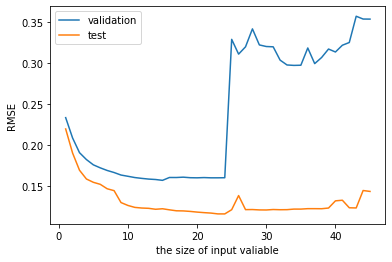

In [89]:
plt.plot(list(range(1,46)),RMSE,label="validation")
plt.plot(list(range(1,46)),testRMSE,label="test")
plt.legend()
plt.xlabel("the size of input valiable")
plt.ylabel("RMSE")
plt.show()